In [1]:
import pickle
import part_1
import os
import numpy as np
import json
import pandas as pd
import pprint
import re
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report


def load_pickle(file_path, json_file=False):
    with open(file_path, 'rb') as f:
        if json_file:
            return json.load(f)
        else:
            return pickle.load(f)


def get_score(report, filter_class):
    lines = report.split('\n')
    f1_score = False
    for line in lines[2:-3]:
        row_data = [a for a in line.split(" ") if a != '']
        row_class = row_data[0].strip()
        
        if  row_class == filter_class: 
            precision = float(row_data[1])
            recall = float(row_data[2])
            f1_score = float(row_data[3])
            support = float(row_data[3])
            break

    return [precision, recall, f1_score, support]


DIR = "2019-01-11 17:35:16.028132"
VOCAB = load_pickle(os.path.join('Graphs_datetime', DIR, 'vocab.pickle'))
ORIGINAL_MODEL = load_pickle(os.path.join('Graphs_datetime', DIR, 'model.pickle'))
ORIGINAL_REPORT = load_pickle(os.path.join('Graphs_datetime', DIR, 'classification_report.pickle'))
ORIGINAL_RUNCONFIG = load_pickle(os.path.join('Graphs_datetime', DIR, 'run_config.json'), True)        
print(ORIGINAL_REPORT)
pprint.pprint(ORIGINAL_RUNCONFIG)

Using TensorFlow backend.


              precision    recall  f1-score   support

     factoid       0.95      0.47      0.63        77
        list       0.76      0.93      0.83        40
     summary       0.61      0.94      0.74        50
       yesno       0.95      1.00      0.98        59

   micro avg       0.79      0.79      0.79       226
   macro avg       0.82      0.83      0.79       226
weighted avg       0.84      0.79      0.78       226

{'BATCH_SIZE': 128,
 'CROSS_VALIDATION': False,
 'DROPOUT': 0.3,
 'EPOCHS': 100,
 'LEARNING_RATE': 0.001,
 'STEM': False,
 'TEST_SPLIT': 0.1,
 'TRAINABLE_EMBEDDING': False,
 'USE_CONV': True,
 'USE_W2V_EMBED': True,
 'VALIDATION_SPLIT': 0.1,
 'WORD2VEC_PARAMS': {'min_count': 5,
                     'negative': 5,
                     'sg': 0,
                     'size': 100,
                     'window': 10,
                     'workers': 16}}


In [4]:
token_sizes = [1000, 6000, 11000, 22000]
aggregates = {
    'factoid': {
        'best_run_mean_f1': [0, 0, 0, 0],
        'best_run_high_f1': [0, 0, 0, 0]
    },
    'summary': {
        'best_run_mean_f1': [0, 0, 0, 0],
        'best_run_high_f1': [0, 0, 0, 0]
    },
}

for root, dirs, files in os.walk("./Graph_3/"):

    for file in files:
        inc_class, xtra_tokens, l_rate, dropout, batch_size = root.split('/')[-1].split('_')
        
        if 'classification_report.pickle' in file:            
            agg_f1_score = []
            score_index = token_sizes.index(int(xtra_tokens))
            report = load_pickle(os.path.join(root, file))


            for line in report.split('\n')[2:-3]:
                row_data = [a for a in line.split(" ") if a != '']
                if len(row_data) == 0:
                    break
                    
                row_class = row_data[0]
                precision = float(row_data[1])
                recall = float(row_data[2])
                f1_score = float(row_data[3])
                support = float(row_data[4])                
                agg_f1_score.append(f1_score)

                if row_class in aggregates.keys():
                    best_run_high_f1 = aggregates[inc_class]['best_run_high_f1'][score_index]
                    if f1_score >= best_run_high_f1:
                        aggregates[inc_class]['best_run_high_f1'][score_index] = np.round(f1_score,2)
            
            f1_mean = np.mean(agg_f1_score)
            best_mean_f1 = aggregates[inc_class]['best_run_mean_f1'][score_index]
            if f1_mean >= best_mean_f1:
                aggregates[inc_class]['best_run_mean_f1'][score_index] = np.round(f1_mean, 2)                
                print(best_mean_f1, "is new best mean_f1.")
                print("Path: ", os.path.join(root, file))

aggregates

0 is new best mean_f1.
Path:  ./Graph_3/factoid_6000_0.0001_0.3_512/classification_report.pickle
0 is new best mean_f1.
Path:  ./Graph_3/summary_11000_0.0001_0.5_125/classification_report.pickle
0 is new best mean_f1.
Path:  ./Graph_3/factoid_11000_0.001_0.3_1024/classification_report.pickle
0 is new best mean_f1.
Path:  ./Graph_3/summary_1000_0.001_0.7_512/classification_report.pickle
0 is new best mean_f1.
Path:  ./Graph_3/factoid_22000_0.001_0.5_1024/classification_report.pickle
0.09 is new best mean_f1.
Path:  ./Graph_3/summary_1000_0.001_0.7_125/classification_report.pickle
0 is new best mean_f1.
Path:  ./Graph_3/summary_6000_0.01_0.5_1024/classification_report.pickle
0.38 is new best mean_f1.
Path:  ./Graph_3/factoid_6000_0.0001_0.3_125/classification_report.pickle
0.47 is new best mean_f1.
Path:  ./Graph_3/summary_6000_0.001_0.5_1024/classification_report.pickle
0.62 is new best mean_f1.
Path:  ./Graph_3/summary_1000_0.001_0.3_1024/classification_report.pickle
0.62 is new best m

{'factoid': {'best_run_mean_f1': [0.82, 0.82, 0.83, 0.83],
  'best_run_high_f1': [0.78, 0.78, 0.78, 0.78]},
 'summary': {'best_run_mean_f1': [0.82, 0.79, 0.78, 0.4],
  'best_run_high_f1': [0.75, 0.71, 0.69, 0.52]}}

In [5]:
print("Graph 3")
BEST_RUN = load_pickle("./Graph_3/factoid_11000_0.01_0.3_125/classification_report.pickle", False)
print(BEST_RUN)
print("Graph 2")
BEST_GRAPH_2_RUN = load_pickle("./Graph_2/summary_1000_0.01_0.3/classification_report.pickle", False)
print(BEST_GRAPH_2_RUN)

Graph 3
              precision    recall  f1-score   support

     factoid       0.88      0.65      0.75        77
        list       0.81      0.88      0.84        40
     summary       0.65      0.88      0.75        50
       yesno       0.98      0.97      0.97        59

   micro avg       0.82      0.82      0.82       226
   macro avg       0.83      0.84      0.83       226
weighted avg       0.84      0.82      0.82       226

Graph 2
              precision    recall  f1-score   support

     factoid       0.95      0.71      0.81        55
        list       0.90      0.83      0.86        53
     summary       0.77      0.94      0.85        68
       yesno       0.94      1.00      0.97        50

   micro avg       0.87      0.87      0.87       226
   macro avg       0.89      0.87      0.87       226
weighted avg       0.88      0.87      0.87       226



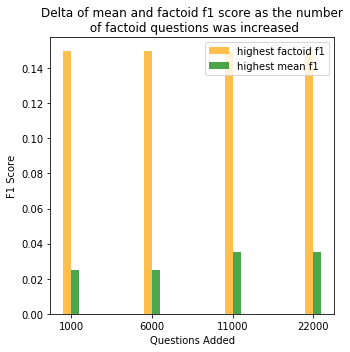

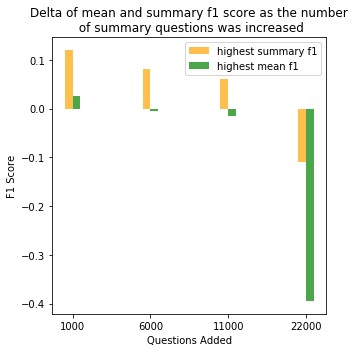

In [6]:
original_factoid_f1_score = get_score(ORIGINAL_REPORT, filter_class='factoid')[2]
original_mean_f1_score = np.mean(
    [get_score(ORIGINAL_REPORT, filter_class=_class)[2] for _class in ['factoid', 'list', 'summary', 'yesno']]
)    

index = np.arange(len(token_sizes))
bar_width = 0.1
opacity = 0.7

for inc_class in ['factoid', 'summary']:
    fig, ax = plt.subplots(figsize=(5, 5))
    error_config = {'ecolor': '0.3'}

    h_f1 = [a-original_factoid_f1_score for a in aggregates[inc_class]['best_run_high_f1']]
    rects1 = ax.bar(index + (bar_width*0), h_f1, bar_width, alpha=opacity, color='orange', label= 'highest ' + inc_class +' f1')
    
    h_mean_f1 = [a-original_mean_f1_score for a in aggregates[inc_class]['best_run_mean_f1']]
    rects1 = ax.bar(index + (bar_width*1), h_mean_f1, bar_width, alpha=opacity, color='green', label= 'highest mean f1')
    
    ax.set_xlabel('Questions Added')
    ax.set_ylabel('F1 Score')
    ax.set_title('Delta of mean and '+inc_class+' f1 score as the number\n of '+inc_class+' questions was increased')
    ax.set_xticks(index + (bar_width*0.5))
    ax.set_xticklabels(token_sizes)
    ax.legend()
    fig.tight_layout()
    plt.show()
    fig.savefig('part_2.png')

In [187]:
pred_1, pred_2 = load_pickle('predictions.pickle')

In [195]:
dup_preds = [p1 for p1,p2 in zip(pred_1, pred_2) if p1 == p2]
np.unique(dup_preds, return_counts=True)

(array(['factoid', 'list', 'summary', 'yesno'], dtype='<U7'),
 array([16159,  1034, 56657, 20490]))